# Курсовой проект Василия Редькина (VRSTATICK)-Кагл
Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

### 1 подключение библиотек

In [1]:
# основные библиотеки
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
from datetime import datetime
import seaborn as sns

# Разделение датасета
from sklearn.model_selection import train_test_split

# Модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor

# метрика
from sklearn.metrics import r2_score

#стандартизация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#подбор параметров
from sklearn.model_selection import GridSearchCV



Далее скопировал из базового решения фунцию, котрая расчитывает метрики и строит графики

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### 2 Загрузка данных

In [3]:
df_test = pd.read_csv('test.csv', sep=',')
df_train = pd.read_csv('train.csv', sep=',')
sample = pd.read_csv('sample_submission.csv', sep = ',')

#### Описание данных
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

### 3 EDA
Здесь я зделал в виде гистограм. В черновом варианте одтельно смотрел каждый признак использовал функции(deskribe(), value_counts, medians(), mode(), quantile()) так же строил отдельно графики для каждого признака 

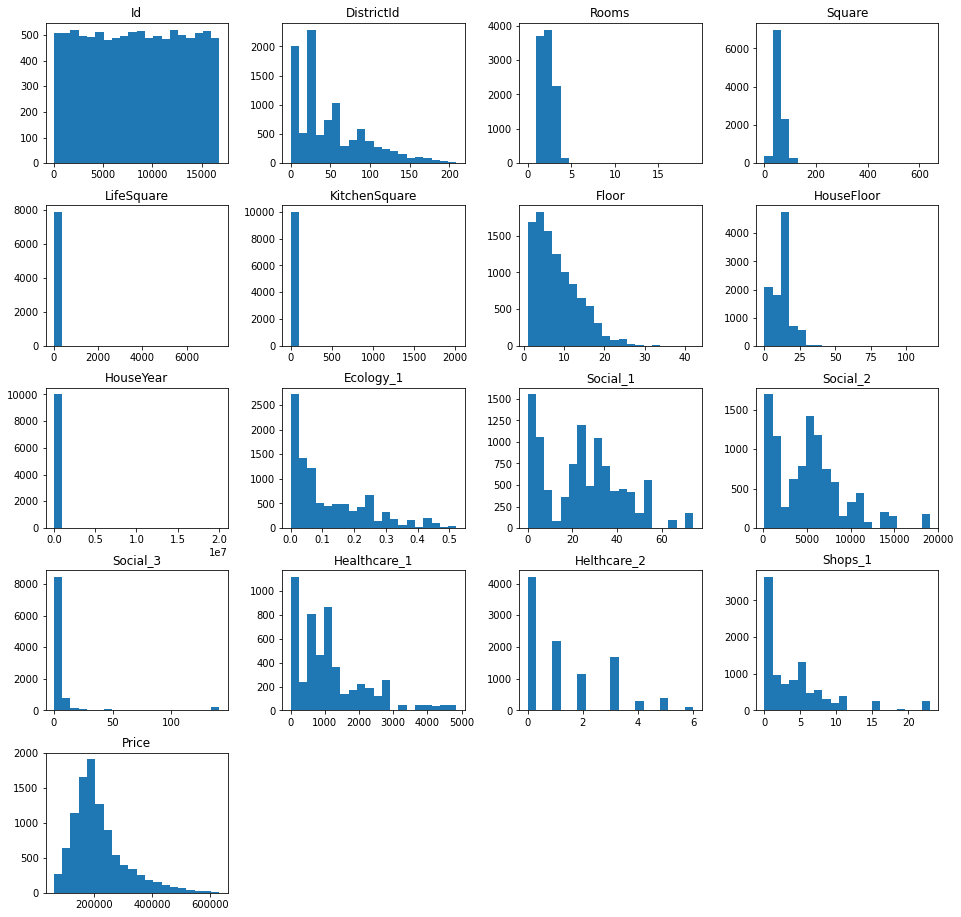

In [4]:
df_train.hist(figsize=(16, 16), bins=20, grid=False);

### 4 подготовка данных
подготорка данных к загрузке в модель(работа с пропусками, выбросами, генерация новых фич(признаков))
сначала написаны два класса а затем применение этих классов

FeatureGenetator() я скопировал с бозового решания

DataPreprocessing() я уже писал сам.
        Метод fit принимает тренировочные данные. В данном методе нем производиться расчет медиан, а так же обучение модели для  заполнения пропусков признака Healthcare_1. В черновом варианте я тестил линейную модель она показала себя хуже чем SVC, так же в черновом варианте я разбивал данные на тренировочный и валидационный и уже смотрел как ведут себя модельки. за тренировочный вариант я брал данные с заполненым признаком Healthcare_1, а за тестовый пропуски. Метод transform принимает и тренировочные данные и тестовые. Он заполняет пропуски, обрабатывает выбросы и кластеризует признаки

In [5]:
class DataPreprocessing:
    

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, df):
        
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = df.median()
        self.kitchen_square_quantile = df['KitchenSquare'].quantile(.975)
        self.mean_work_square = (df.Square - df.KitchenSquare - df.LifeSquare).mean()
        
        
        # Обучение модели для заполнения пропусков Healthcare_1
        
        
        # создаем тестовые данные где нет пропусков в признаке Healthcare_1
        df_Healthcare_1_train = df[df.Healthcare_1.notnull()] 
        
        # выбираем необходимае признаки для модельки
        self.names = [
                'Rooms','Square',
                'KitchenSquare','Floor','HouseFloor','HouseYear',
                'Ecology_1','Social_1',
                'Social_2','Social_3','Helthcare_2','Shops_1']
        
        # разбиваем на X и у
        X_train = df_Healthcare_1_train[self.names]
        y_train = df_Healthcare_1_train['Healthcare_1']
        
        # стандартизируем данные
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        
        #обучаем модель
        self.model_Healthcare_1 = SVC(gamma="auto")
        self.model_Healthcare_1.fit(X_train_scaled, y_train)
        
    def transform(self, df):
        
        # Заполнение пропусков жилой прощади расчетом (общая площадь - среднее значение рабочей зоны в квартирах)
        df.LifeSquare.fillna((df.Square - self.mean_work_square), inplace=True)
        
        # заполнение пропусков Healthcare_1
        
        #создаем тестовые данные(для модели) где есть пропуски
        df_Healthcare_1_test = df[df.Healthcare_1.isnull()]
        #предсказываем пропуски в Healthcare_1
        Healthcare_1_pred = self.model_Healthcare_1.predict(df_Healthcare_1_test[self.names])
        #заполняем предсказанными данными пропуски в Healthcare_1
        df.Healthcare_1.fillna(pd.Series(Healthcare_1_pred), inplace=True)
        
        
        # отработка выбросов по комнатам
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #отработка выбросов по общей площади
        condition = (df['Square'] > 300)|(df['Square'] < 13)
        df.loc[condition, 'Square'] = self.medians['Square']
        
        #отработка выбросов по площади кухни
        condition = (df['KitchenSquare'] > self.kitchen_square_quantile)
        df.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        #разбаваем бинарные признаки
        
        #Ecology_2
        
        binary_to_Ecology_2 = pd.get_dummies(df['Ecology_2'])
        binary_to_Ecology_2.columns = ['Ecology_2_A','Ecology_2_B']
        df = pd.concat([df, binary_to_Ecology_2], axis=1)
        
        #Ecology_3
        
        binary_to_Ecology_3 = pd.get_dummies(df['Ecology_3'])
        binary_to_Ecology_3.columns = ['Ecology_3_A','Ecology_3_B']
        df = pd.concat([df, binary_to_Ecology_3], axis=1)
        
        #Shops_2
        
        binary_to_Shops_2 = pd.get_dummies(df['Shops_2'])
        binary_to_Shops_2.columns = ['Shops_2_A','Shops_2_B']
        df = pd.concat([df, binary_to_Shops_2], axis=1)
        
        #Helthcare_2
        
        binary_to_Helthcare_2 = pd.get_dummies(df['Helthcare_2'])
        binary_to_Helthcare_2.columns = ['Helthcare_2_0','Helthcare_2_1','Helthcare_2_2',
                             'Helthcare_2_3','Helthcare_2_4','Helthcare_2_5','Helthcare_2_6']
        df = pd.concat([df, binary_to_Helthcare_2], axis=1)
        
        # Shops_1
        
        binary_to_Shops_1 = pd.get_dummies(df['Shops_1'])
        binary_to_Shops_1.columns = ['Shops_1_0','Shops_1_1','Shops_1_5','Shops_1_2','Shops_1_4','Shops_1_3',
                                 'Shops_1_6','Shops_1_11','Shops_1_9','Shops_1_7','Shops_1_8','Shops_1_23',
                                 'Shops_1_10','Shops_1_15','Shops_1_16','Shops_1_19'
                                ]
        df = pd.concat([df, binary_to_Shops_1], axis=1)
        
        # заполняем пропуски медианой если они вдруг появились
        df.fillna(self.medians, inplace=True)
        return df

In [6]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [7]:
#создаем Х и у
X = df_train.drop(columns = 'Price')
y = df_train['Price']

In [8]:
# разбиваем на тренировочный и валидационный
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [9]:
# применяем классы к данным
Preprocessing = DataPreprocessing() 
Preprocessing.fit(X_train)
X_train = Preprocessing.transform(X_train)
X_valid = Preprocessing.transform(X_valid)
df_test = Preprocessing.transform(df_test)

/home/vasiliy/.local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/vasiliy/.local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-5-6ad7b9476534>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rooms

In [10]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

In [11]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5',
 'Helthcare_2_6',
 'Shops_1_0',
 'Shops_1_1',
 'Shops_1_5',
 'Shops_1_2',
 'Shops_1_4',
 'Shops_1_3',
 'Shops_1_6',
 'Shops_1_11',
 'Shops_1_9',
 'Shops_1_7',
 'Shops_1_8',
 'Shops_1_23',
 'Shops_1_10',
 'Shops_1_15',
 'Shops_1_16',
 'Shops_1_19',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByFloorYear']

In [12]:
#отбираем признаки
new_feature_names_predict_7 = [
    'Rooms','Square','LifeSquare',
    'KitchenSquare','Floor','HouseFloor','HouseYear',
    'Ecology_1','Social_1',
    'Social_2','Social_3','Healthcare_1','Shops_1',
    'Rooms_outlier','HouseFloor_outlier','HouseYear_outlier',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_2_B', 'Shops_2_A', 'Shops_2_A',
    'Helthcare_2_0','Helthcare_2_1','Helthcare_2_2','Helthcare_2_3','Helthcare_2_4','Helthcare_2_5','Helthcare_2_6',
    'floor_cat','year_cat','MedPriceByFloorYear','IsDistrictLarge','DistrictSize'
]

### 5 Построение модели
Здесь оставил лучшую модель 
В черновом варианте строил модель смотрел метрики затем смотрел важность признаков и выбирал тем самым признаки при которых модель точнее предсказывает. Затем выбрав модель я стал подбирать лучшие параметры для нее с помощью GridSearchCV. После GridSearchCV еще вручную подбирал немного. После подбора параметров попытался построить более сложную модель с помощью StackingRegressor но данныя модель показала хуже метрики чем GradientBoostingRegressor.

In [13]:
%%time
#построение модели
final_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=10,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2000, 
                                     max_features='sqrt',
                                     loss='huber', 
                                     learning_rate=0.025)
final_model.fit(X_train[new_feature_names_predict_7], y_train)

CPU times: user 1min 11s, sys: 623 ms, total: 1min 12s
Wall time: 1min 12s


GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=10, max_features='sqrt',
                          min_samples_leaf=50, n_estimators=2000,
                          random_state=42)

In [13]:
#приедсказавание данных
y_pred_train = final_model.predict(X_train[new_feature_names_predict_7])
y_pred_valid = final_model.predict(X_valid[new_feature_names_predict_7])

Train R2:	0.887
Test R2:	0.755


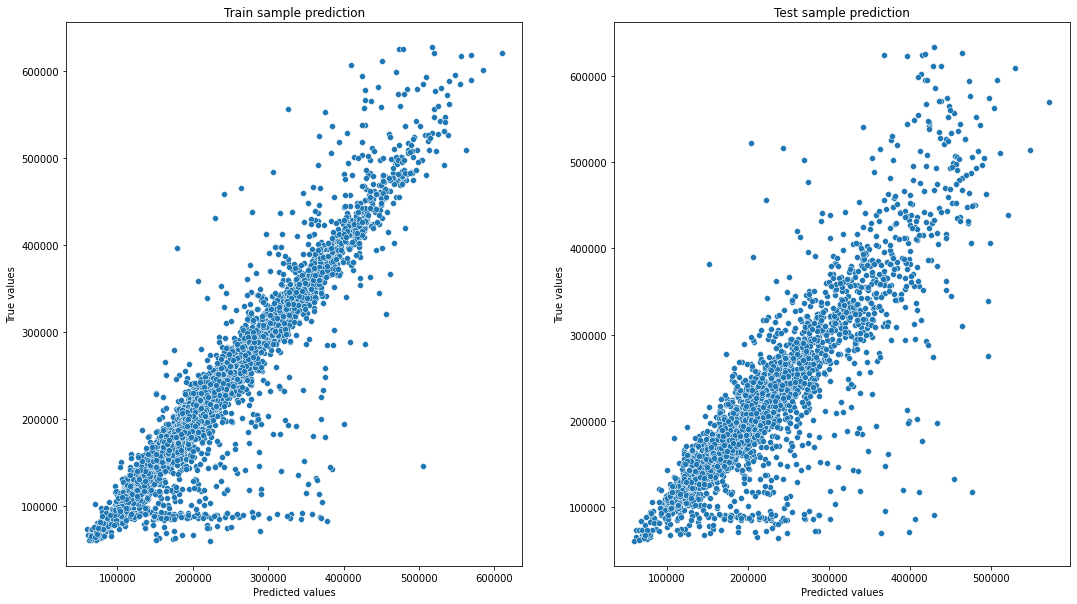

In [14]:
#смотрим метрики
evaluate_preds(y_train, y_pred_train, y_valid, y_pred_valid)

In [236]:
# смотрим важность признаков
feature_importances = pd.DataFrame(zip(X_train[new_feature_names_predict_7].columns, 
                                       model_3.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [237]:
feature_importances

,feature_name,importance
1,Square,0.225549
2,LifeSquare,0.131637
0,Rooms,0.098334
30,IsDistrictLarge,0.069512
31,DistrictSize,0.064012
3,KitchenSquare,0.052167
9,Social_2,0.050991
10,Social_3,0.050974
6,HouseYear,0.038457
7,Ecology_1,0.035403


In [83]:
# подбор параметров
params = {'n_estimators':[1750, 2000, 2250, 2500], 
          'max_depth':[5, 6, 7, 8]}
gs = GridSearchCV(model_3,
                  params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                  random_state=21, 
                  shuffle=True),
                  n_jobs=-1
                 )
gs.fit(X_train[new_feature_names_predict_7], y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 learning_rate=0.025,
                                                 loss='huber', max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 n_estimators=900,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8],
                         'n_estimators': [1750, 2000, 2250, 2500]},
             scoring='r2')

In [84]:
#лучшие параметры
gs.best_params_

{'max_depth': 8, 'n_estimators': 2000}

In [278]:
%%time
#попытка построить новую-улучшенную модель
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()

#обучаем модель
stack = StackingRegressor([('lr', lr), ('rf', final_model)], final_estimator=gb)
#stack.fit(X_train[new_feature_names_predict_7], y_train)

In [280]:
#предсказаваем данные
y_pred_train = stack.predict(X_train[new_feature_names_predict_7])
y_pred_valid = stack.predict(X_valid[new_feature_names_predict_7])

Train R2:	0.864
Test R2:	0.747


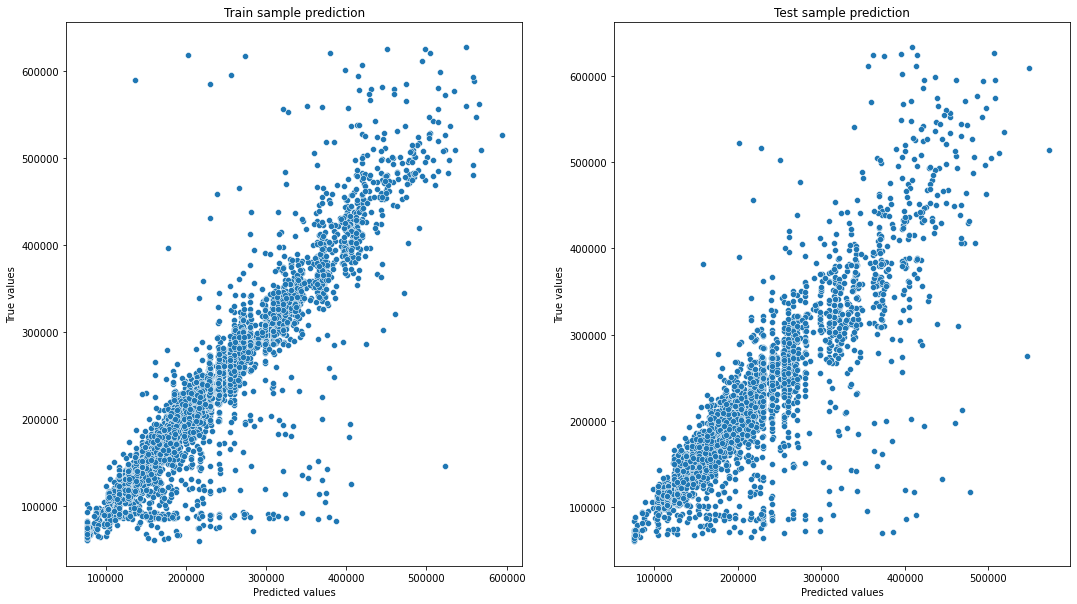

In [281]:
#смотрим метрики
evaluate_preds(y_train, y_pred_train, y_valid, y_pred_valid)

### 6 Предсказание на тестовых данных и выгрузка

In [288]:

predict = final_model.predict(df_test[new_feature_names_predict_7])

In [289]:
sample['Price'] = predict

In [290]:
sample.to_csv('predict_final_model.csv', index=False)